In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from module.pricing import option_bs
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

__Input__

In [2]:
spot = 100
sigma = 0.2
T = 1
r = 0

__Run__

In [3]:
strikes = [
    spot*(1-sigma*2),
    spot*(1-sigma),
    spot,
    spot*(1+sigma),
    spot*(1+sigma*2),
]
strikes = [np.round(strike) for strike in strikes]

global_results = dict()
for strike in strikes:
    for bump in (-1, -0.5, 0, 0.5, 1):
        spot_bumped = spot * (1 + sigma*bump)
        pricing_results = option_bs(option_type='call', S=spot_bumped, K=strike, T=T, r=r, sigma=sigma)
        gamma_cash = (spot_bumped**2 * pricing_results['Gamma']) / 100
        global_results[(strike, bump)] = gamma_cash

matrix = pd.Series(global_results).unstack().unstack().unstack()
gamma_cash_target = pd.Series([1e6] * matrix.shape[0], index=matrix.index)
matirx_inv = pd.DataFrame(np.linalg.pinv(matrix.values), matrix.columns, matrix.index)
weights = np.round(matirx_inv.dot(gamma_cash_target))

__Matrix: Gamma Cash Strike Option x Spot Bump__

In [4]:
matirx_inv.dot(matrix)

,60.00,80.00,100.00,120.00,140.00
60.00,1.00,0.00,-0.00,0.00,0.00
80.00,-0.00,1.00,0.00,0.00,-0.00
100.00,0.00,0.00,1.00,-0.00,-0.00
120.00,-0.00,-0.00,0.00,1.00,0.00
140.00,0.00,0.00,-0.00,0.00,1.00


__Weights For 1mio Constant Gamma Cash__

In [5]:
weights

60.00    601,575.00
80.00    279,611.00
100.00   255,323.00
120.00    32,972.00
140.00   252,657.00
dtype: float64

In [6]:
matrix.dot(weights)

-1.00     999,999.91
-0.50   1,000,000.20
0.00    1,000,000.40
0.50    1,000,000.39
1.00    1,000,000.24
dtype: float64

In [7]:
gamma_cash_package = dict()
theta_package = dict()
for spot_ in range(1, int(spot*(1+sigma*3))+100, 1):
    gamma_cash_sum = 0
    theta_sum = 0
    for strike in strikes:
        pricing_results = option_bs(option_type='call', S=spot_, K=strike, T=T, r=r, sigma=sigma)
        gamma_cash = (spot_**2 * pricing_results['Gamma']) / 100
        gamma_cash *= weights[strike]
        gamma_cash_sum = gamma_cash_sum + gamma_cash
        theta_sum = theta_sum + (pricing_results['Theta']*weights[strike])
    gamma_cash_package[spot_] = gamma_cash_sum
    theta_package[spot_] = theta_sum
gamma_cash_package = pd.Series(gamma_cash_package)
theta_package = pd.Series(theta_package)


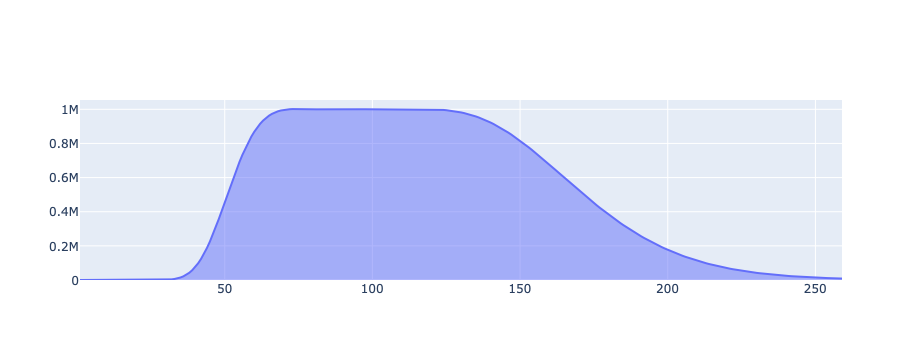

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=gamma_cash_package.index, y=gamma_cash_package.values, fill='tozeroy'))